<center><img src="https://miro.medium.com/v2/resize:fit:300/0*gTbWMTKvNF-jLJrM.jpg" width=30% ></center>

# <center> Assignment 3: Harris Corner Detector & Optical Flow </center>
<center> Computer Vision 1, University of Amsterdam </center>
    <center> Due 23:59PM, September 30, 2023 (Amsterdam time) </center>
    
  ***
<center>
<b>TA's: Melis Öcal, Ronny Velastegui Sandoval</b>

Student1 ID: 14895730
Student1 Name:Luis Vitor Zerkowski

Student2 ID: 14232332
Student2 Name:Tanya Kaintura

Student3 ID: 12538019
Student3 Name:Jelle van der Lee 


# General Guidelines

Your code and discussion must be handed in this jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Lab 3 Assignment. Please also fill out your names and ID's above.

For full credit, make sure your notebook follows these guidelines:
- It is mandatory to use the Python environment provided with the assignment; the environment specifies the package versions that have to be used to prevent the use of particular functions. Using different packages versions may lead to grade deduction. In the 'Environment Setup' below you can check whether your environment is set up correctly.
- To install the environment with the right package versions, use the following command in your terminal: ```python
conda env create --file=CV1_environment.yaml```, then activate the environment using the command ```python conda activate cv1```.
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions and sub-questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make the notebook self-contained and complete.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.

__Note:__ A more complete overview of the lab requirements can be found in the Course Manual on Canvas

Late submissions are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.

Plagiarism note: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations. This includes the use of generative tools such as ChatGPT.

**ENSURE THAT YOU SAVE ALL RESULTS / ANSWERS ON THE QUESTIONS (EVEN IF YOU RE-USE SOME CODE).**

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import maximum_filter
from scipy import signal
import os
import matplotlib
import scipy

In [2]:
# Make sure you're using the provided environment!
assert cv2.__version__ == "3.4.2", "You're not using the provided Python environment!"
assert np.__version__ == "1.19.5", "You're not using the provided Python environment!"
assert matplotlib.__version__ == "3.3.4", "You're not using the provided Python environment!"
assert scipy.__version__ == "1.5.4", "You're not using the provided Python environment!"
# Proceed to the next cell if you don't get any error.

# 1. Harris Corner Detector (45pts)
In this section, a derivation of the *[Harris Corner Detector](https://www.semanticscholar.org/paper/A-Combined-Corner-and-Edge-Detector-Harris-Stephens/6818668fb895d95861a2eb9673ddc3a41e27b3b3)* is presented.

Given a shift $(\Delta x,\Delta y)$ at a point $(x, y)$, the auto-correlation function is defined as:

$$c(\Delta x,\Delta y) = \sum\limits_{(x,y)\in W(x,y)} {w(x,y)(I(x+\Delta x,y+\Delta y)-I(x,y))^2} \tag {1}$$

where $W(x,y)$ is a window centered at point $(x,y)$ and $w(x,y)$ is a Gaussian function. For simplicity, from now on, $\sum\limits_{(x,y)\in W(x,y)}$ will be referred to as $\sum\limits_{W}$.
Approximating the shifted function by the first-order Taylor expansion we get:

\begin{eqnarray}
I(x+\Delta x,y+ \Delta y) & \approx & I(x,y) + I_x(x,y)\Delta x + I_y(x,y)\Delta y \tag {2} \\
&=& I(x,y) + [I_x(x,y) \ I_y(x,y)] \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}, \tag {3}
\end{eqnarray}

where $I_x$ and $I_y$ are partial derivatives of $I(x,y)$. The first gradients can be approximated by:
\begin{eqnarray}
    I_x &=& \frac{\partial I}{\partial x} \approx I * G_x, \quad G_x = (-1,0,1) \tag {4} \\
    I_y &=& \frac{\partial I}{\partial y} \approx I * G_y, \quad G_y = (-1,0,1)^T \tag {5}
\end{eqnarray}


Note that using the kernel $(-1, 1)$ to approximate the gradients is also correct. The auto-correlation function can now be written as:
\begin{eqnarray}
c(\Delta x,\Delta y) &=& \sum\limits_{W} {w(x,y) (I(x+\Delta x,y+\Delta y)-I(x,y))^2} \tag {6} \\
& \approx & \sum\limits_{W} {w(x,y) ([I_x(x,y) \ I_y(x,y)]\begin{bmatrix} \Delta x \\
\Delta y \end{bmatrix})^2} \tag {7} \\
&=& [\Delta x \ \Delta y]Q(x,y)\begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}, \, \tag {8}
\end{eqnarray}

where $Q(x,y)$ is given by:

\begin{eqnarray}
Q(x,y) &=& \sum\limits_{W} w(x,y){\begin{bmatrix} I_x(x,y)^2  & I_x(x,y)I_y(x,y)  \\  I_x(x,y)I_y(x,y)  & I_y(x,y)^2   \end{bmatrix}} \tag {9} \\
&=& \begin{bmatrix}
\sum\limits_{W}{I_x(x,y)^2} * w(x, y) & \sum\limits_{W}{I_x(x,y)I_y(x,y)} * w(x, y) \\  
\sum\limits_{W}{I_x(x,y)I_y(x,y)} * w(x, y) & \sum\limits_{W}{I_y(x,y)^2} * w(x, y)  \end{bmatrix} \tag {10}\\
&=& \begin{bmatrix} A & B \\  B & C  \end{bmatrix}.\, \tag {11}
\end{eqnarray}

The *cornerness* $H(x,y)$ is defined by the two eigenvalues of $Q(x,y)$, e.g. $\lambda_1$ and $\lambda_2$:

\begin{eqnarray}
\label{eq12}
H &=& \lambda_1 \lambda_2 - 0.04(\lambda_1 + \lambda_2)^2 \tag{12}\\
&=& det(Q) - 0.04(trace(Q))^2 \tag{13}\\
&=& (AC - B^2) - 0.04(A+C)^2. \ \tag{14}
\end{eqnarray}

In this section, you are going to implement $Equation ~\eqref{eq12}$ to calculate $H$ and use it to detect the corners in an image.

**Hint**: For that purpose, you need to compute the elements of **Q**, i.e. $A$, $B$ and $C$. To do that, you need to calculate $I_x$, which is the smoothed derivative of the image. That can be obtained by convolving the first order Gaussian derivative, $G_d$, with the image $I$ along the x-direction. Then, **A** can be obtained by squaring $I_x$, and then convolving it with a Gaussian, $G$. Similarly, **B** and **C** can be obtained. For example, to get **C**, you need to convolve the image with $G_d$ along the y-direction (to obtain $I_y$), raise it to the square, then convolve it with $G$.

**Hint**: The corner points are the local maxima of **H**. Therefore, you should check for every point in $H$, (1) if it is greater than all its neighbours (in an $n \times n$ window centered around this point) and (2) if it is greater than the user-defined threshold. If both conditions are met, then the point is labeled as a corner point.

## Question 1.1 (35-*pts*)
    
**1.1.1** Create a function to implement the Harris Corner Detector. Your function should return matrix $H$, the indices of rows of the detected corner points **r**, and the indices of columns of those points **c**, where the first corner is given by $(r[0],c[0])$. **[20pts]**

    
**1.1.2** Implement another function that plots three figures: The computed image derivatives $I_x$ and $I_y$, and the original image with the corner points plotted on it. Show your results on example images **checkerboard.jpg** and **house.jpg**. Remember to experiment with different threshold values to see the impact on which corners are found. **[5pts]**
    
    
**1.1.3** Is the algorithm rotation-invariant? How about your implementation? Rotate **checkerboard.jpg** image 45 and 90 degrees and run the Harris Corner Detector algorithm on the rotated images. Explain your answer and support it with your observations. **[10pts]**

*Note:* You are allowed to use *scipy.signal.convolve2d* to perform convolution, and *scipy.ndimage.gaussian\_filter* to obtain your image derivatives.
Include a demo function to run your code.

10 10


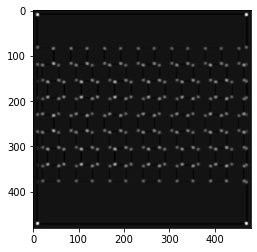

In [3]:
from scipy.ndimage import gaussian_filter, rotate
from scipy.signal import convolve2d

def img2gray(img_path):
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return img_gray


def gradient_x(img_gray):
    """
    Compute and return the derivative of the image in the x direction
    """
    # --------------
    # YOUR CODE HERE
    # --------------
    kernel = np.array([[-1, 0, 1]])  # First-order Gaussian derivative along the x-direction
    img_dx = convolve2d(img_gray, kernel, mode='same', boundary='symm')
    return img_dx

def gradient_y(img_gray):
    """
    Compute and return the derivative of the image in the y direction
    """
    # --------------
    # YOUR CODE HERE
    # --------------
    kernel = np.array([[-1], [0], [1]])
    img_dy = convolve2d(img_gray, kernel, mode='same', boundary='symm')
    return img_dy

def haris_corner_detector(img_path, sigma, threshold, rotation = 0):
    """
    Implement the Harris Corner Detector function as described above.
    Remember, your function should return matrix H, the indices of rows of
    the detected corner points r, and the indices of columns of those points
    c, where the first corner is given by (r[0],c[0]).
    """
    # --------------
    # YOUR CODE HERE
    # --------------
    img_gray = img2gray(img_path)
    
    img_gray = rotate(img_gray, rotation)

    
    # Compute image derivatives
    I_x = gradient_x(img_gray)
    I_y = gradient_y(img_gray)
    
    # Calculate Harris components
    I_x2 = I_x**2
    I_y2 = I_y**2
    I_xy = I_x * I_y

    # Gaussian smoothing for the components
    I_x2 = gaussian_filter(I_x2, sigma)
    I_y2 = gaussian_filter(I_y2, sigma)
    I_xy = gaussian_filter(I_xy, sigma)

    # Compute Harris matrix H
    det_H = I_x2 * I_y2 - I_xy**2
    trace_H = I_x2 + I_y2
    harris_response = det_H - 0.04 * trace_H**2

    # Non-maximum suppression
    harris_response_max = maximum_filter(harris_response, size=(3, 3))
    corners = (harris_response == harris_response_max) & (harris_response > threshold)
#     corners = harris_response > threshold

    # Get the indices of detected corners
    r, c = np.where(corners)

    return harris_response, r, c


# --------------
# YOUR CODE HERE
# --------------
# If you need to test your function

harris_response, r_c, c_c = haris_corner_detector('./data/checkerboard.jpg', sigma=2, threshold=25, rotation=0)
print(r_c[0],c_c[0])

# Dilate corner image to enhance corner points
dst = cv2.dilate(harris_response,None)
plt.imshow(dst, cmap='gray')

                                        

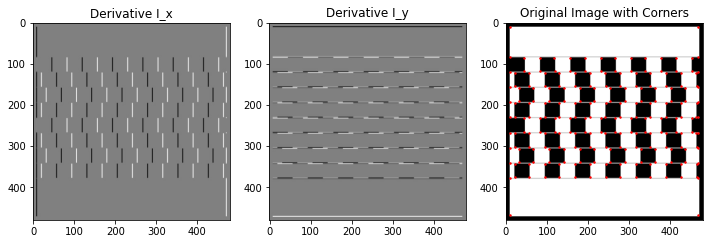

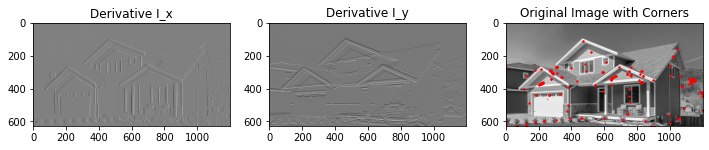

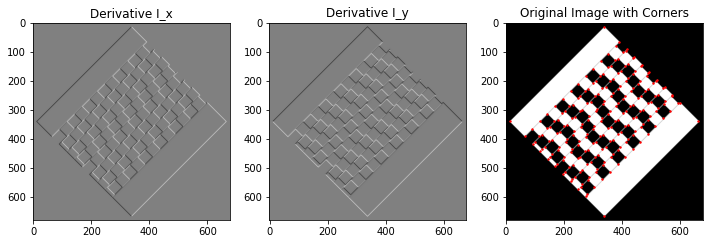

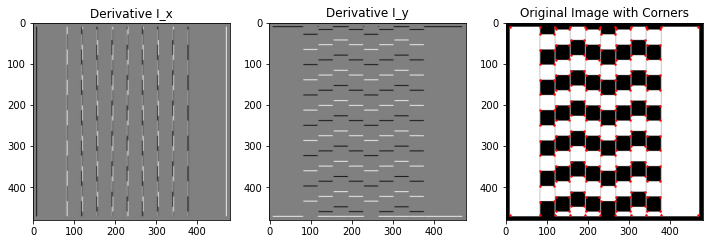

In [4]:
# Now implement another function that plots three figures: The computed image
# derivatives  𝐼_x, 𝐼_y and the original image with the corner points plotted
# on it. Show your results on example images checkerboard.jpg and
# house.jpg. Remember to experiment with different threshold values
# to see the impact on which corners are found.

from scipy.ndimage import rotate

# Import the images
img_path_checkerboard = './data/checkerboard.jpg'
img_path_house = './data/house.jpg'

img_checkerboard = img2gray(img_path_checkerboard)
img_house = img2gray(img_path_house)

# --------------
# YOUR CODE HERE
# --------------
# Solve the rest of the exercise as asked above.


def plot_corners_and_derivatives(img_gray, I_x, I_y, r, c):
    plt.figure(figsize=(12, 4))

    plt.subplot(131)
    plt.imshow(I_x, cmap='gray')
    plt.title('Derivative I_x')

    plt.subplot(132)
    plt.imshow(I_y, cmap='gray')
    plt.title('Derivative I_y')

    plt.subplot(133)
    plt.imshow(img_gray, cmap='gray')
    plt.scatter(c, r, s=2, c='red', marker='o')
    plt.title('Original Image with Corners')

    plt.show()
    
plot_corners_and_derivatives(img_checkerboard, gradient_x(img_checkerboard), gradient_y(img_checkerboard), r_c, c_c)

harris_response, r_h, c_h = haris_corner_detector('./data/house.jpg', sigma=20, threshold=40000, rotation=0)
plot_corners_and_derivatives(img_house, gradient_x(img_house), gradient_y(img_house), r_h, c_h)

# Rotate the checkerboard image by 45 and 90 degrees
img_rotated_45 = rotate(img2gray(img_path_checkerboard), 45)
img_rotated_90 = rotate(img2gray(img_path_checkerboard), 90)

harris_response, r_c45, c_c45 = haris_corner_detector('./data/checkerboard.jpg', sigma=2, threshold=25, rotation=45)
harris_response, r_c90, c_c90 = haris_corner_detector('./data/checkerboard.jpg', sigma=2, threshold=25, rotation=90)

plot_corners_and_derivatives(img_rotated_45, gradient_x(img_rotated_45), gradient_y(img_rotated_45), r_c45, c_c45)
plot_corners_and_derivatives(img_rotated_90, gradient_x(img_rotated_90), gradient_y(img_rotated_90), r_c90, c_c90)


*The Harris Corner Detector algorithm calculates the corner response based on the derivatives of the image, and it is inherently invariant to image rotation.*

*In the Harris Corner Detector algorithm:*

1. *The corner response (R) is calculated as R = det(M) - k * (trace(M))^2, where M is the Harris matrix, and k is an empirical constant.*
2. *The Harris matrix M is computed using the image derivatives, and it quantifies the local structure of the image.*
3. *The Harris response R is used to detect corners. High values of R indicate corners, regardless of the image's orientation.*

*Because the Harris response is calculated based on local image properties such as gradients and their covariances, it remains consistent for the same corner, even if the image is rotated. This means that the same corner in an image will have a similar Harris response regardless of its orientation. Given in the images the algorithem still detects the same corners in even rotation. for example the 4 corner points in all the image.*

## Question 1.2 (10-*pts*)
    
Now you have seen the cornerness definition of Harris on $Equation ~(12)$. Another relevant definition of cornerness is defined by  *[Shi and Tomasi](https://ieeexplore.ieee.org/document/323794)*, after the original definition of Harris. Check their algorithm and answer the following questions:
    
**1.2.1** How do they define cornerness? Write down their definition using the notations of $Equation ~(12)$. **[3pts]**
    

*Shi and Tomasi define cornerness (H) using the following formula:*

\begin{eqnarray}
H &=& min(\lambda_1 \lambda_2)\\
\end{eqnarray}

*The corner response, H, is defined as the minimum of the two eigenvalues of the structure tensor. It represents how corner-like a pixel is in the image. When H has a high value, it indicates that a pixel is likely to be part of a corner or a prominent feature. This formulation is an essential part of the Shi-Tomasi corner detection method, as it enables the algorithm to select corners based on this cornerness measure, ensuring that only the most distinctive corners are retained for further processing.*

*Instead of using a single corner response value, Shi and Tomasi introduced a scoring function that considers the minimum of the two eigenvalues (λ1 and λ2) of the structure tensor Q.*

**1.2.2** Does the Shi-Tomasi Corner Detector satisfy the following properties: translation invariance, rotation invariance, scale invariance? Explain your reasoning for each property. **[4pts]**
    

*The Shi-Tomasi Corner Detector exhibits the following properties:*

1. *Translation Invariance: The Shi-Tomasi Corner Detector is translation-invariant. This means that if you translate the entire image or the features within the image, the corner detection results will remain consistent. Corners in the image will be detected regardless of their position within the frame. This property is due to the fact that the algorithm relies on local intensity gradients and the properties of the second moment matrix, which are not affected by simple translations.*

2. *Rotation Invariance: The Shi-Tomasi Corner Detector is rotation-invariant. It can detect corners in rotated versions of the image as effectively as in the original image. This property is because it measures the strength of corners based on the eigenvalues of the structure tensor, which captures local gradient information without depending on the orientation of the image. Corners will still be detected even if the image is rotated.*

3. *Scale Invariance: The Shi-Tomasi Corner Detector is not inherently scale-invariant. In other words, if you scale the image or the features within the image (e.g., make objects larger or smaller), the corner detection performance may be affected. The detector's response to corners can be sensitive to changes in the scale of the image or the local structures within it.*

**1.2.3** In the following scenarios, what could be the relative cornerness values assigned by Shi and Tomasi? Explain your reasoning. **[3pts]**

1. Both eigenvalues are near 0.
    
2. One eigenvalue is big and the other is near zero.
    
3. Both eigenvalues are big.

1. *In this scenario, when both eigenvalues are close to zero, it indicates that the local image structure in the selected neighborhood is relatively flat or lacks any pronounced corners. The cornerness measure, as defined by Shi and Tomasi, is calculated as the product of the two smallest eigenvalues of the structure tensor. When both eigenvalues are close to zero, the product will also be close to zero. Therefore, the assigned cornerness value will be very low, signifying that there are no significant corners or edges in the neighborhood.*

2. *When one eigenvalue is significantly larger than the other, it suggests that the local image structure is elongated or exhibits a strong gradient in one direction. The larger eigenvalue corresponds to the direction of the strong gradient, while the smaller eigenvalue indicates a weaker gradient. In this case, the product of the two smallest eigenvalues will be close to zero because one of them is near zero. The assigned cornerness value will be low, indicating that this local structure is more edge-like than corner-like. Corners are characterized by having two relatively large eigenvalues.*

3. *When both eigenvalues are significantly large, it suggests that the local image structure exhibits a pronounced corner. Corners typically have high gradients in two orthogonal directions, leading to large eigenvalues. In this scenario, the product of the two smallest eigenvalues will also be large. The assigned cornerness value will be high, indicating the presence of a strong corner in the selected neighborhood.*

# 2. Optical Flow - Lucas-Kanade Algorithm (35pts)

Optical flow is the apparent motion of image pixels or regions from one frame to the next, which results from moving objects in the image or from camera motion. Underlying optical flow is typically an assumption of $\textit{brightness constancy}$. That is the image values (brightness, color, etc) remain constant over time, though their 2D position in the image may change. Algorithms for estimating optical flow exploit this assumption in various ways to compute a velocity field that describes the horizontal and vertical motion of every pixel in the image. For a 2D+t dimensional case a voxel at location $(x, y, t)$ with intensity $I(x, y, t)$ will have moved by $\delta_x$, $\delta_y$ and $\delta_t$ between the two image frames, and the following image constraint equation can be given:

\begin{equation}
I(x,y,t) = I(x+\delta_x, y+\delta_y, t+\delta_t). \tag{15}
\end{equation}

Assuming the movement to be small, the image constraint at I(x, y, t) can be extended using Taylor series, truncated to first-order terms:

\begin{equation}
\tag{16}
I(x+\delta_x, y+\delta_y, t+\delta_t) = I(x,y,t)+\frac{\partial I}{\partial x}\delta_x +\frac{\partial I}{\partial y}\delta_y+\frac{\partial I}{\partial t}\delta_t
\end{equation}

Since we assume changes in the image can purely be attributed to movement, we will get:

\begin{equation}
\tag{17}
\frac{\partial I}{\partial x}\frac{\delta_x}{\delta_t} +   \frac{\partial I}{\partial y}\frac{\delta_y}{\delta_t} + \frac{\partial I}{\partial t}\frac{\delta_t}{\delta_t} = 0
\end{equation}

or

\begin{equation}
\tag{18}
I_x V_x + I_y V_y = -I_t,
\end{equation}

where $V_x$ and $V_y$ are the $x$ and $y$ components of the velocity or optical flow of $I(x,y,t)$. Further, $I_x$, $I_y$ and $I_t$ are the derivatives of the image at $(x, y, t)$ in the corresponding directions, which defines the main equation of optical flow.

Optical flow is difficult to compute for two main reasons. First, in image regions that are roughly homogeneous, the optical flow is ambiguous, because the brightness constancy assumption is satisfied by many different motions. Second, in real scenes, the assumption is violated at motion boundaries and by miscellaneous lighting, non-rigid motions, shadows, transparency, reflections, etc. To address the former, all optical flow methods make some sort of assumption about the spatial variation of the optical flow that is used to resolve the ambiguity. Those are just assumptions about the world which are approximate and consequently may lead to errors in the flow estimates. The latter problem can be addressed by making much richer but more complicated assumptions about the changing image brightness or, more commonly, using robust statistical methods which can deal with 'violations' of the brightness constancy assumption.

## Lucas-Kanade Algorithm

We will be implementing the [Lucas-Kanade method](https://www.ri.cmu.edu/pub_files/pub3/lucas_bruce_d_1981_2/lucas_bruce_d_1981_2.pdf) for Optical Flow estimation. This method assumes that the optical flow is essentially constant in a local neighborhood of the pixel under consideration. Therefore, the main equation of the optical flow can be assumed to hold for all pixels within a window centered at the pixel under consideration. Let's consider pixel $p$. Then, for all pixels around $p$, the local image flow vector $(V_x, V_y)$ must satisfy:

\begin{array}{c}
\tag{19}
  I_x(q_1)V_x + I_y(q_1)V_y = - I_t(q_1)\\
  I_x(q_2)V_x + I_y(q_2)V_y = - I_t(q_2)\\
  \vdots \\
  I_x(q_n)V_x + I_y(q_n)V_y = - I_t(q_n),\\
\end{array}

where $q_1$, $q_2$, ... $q_n$ are the pixels inside the window around $p$. $I_x(q_i)$, $I_y(q_i)$, $I_t(q_i)$ are the partial derivatives of the image $I$ with respect to position $x$, $y$ and time $t$, evaluated at the point $q_i$ and at the current time.

These equations can be written in matrix to form $Av=b$, where

\begin{equation}
\tag{20}
A = \begin{bmatrix}
I_x(q_1) & I_y(q_1)\\
I_x(q_2) & I_y(q_2)\\
\vdots   & \vdots  \\
I_x(q_n) & I_y(q_n)
\end{bmatrix},
v = \begin{bmatrix}
V_x\\ V_y
\end{bmatrix}, \mbox{ and }
b = \begin{bmatrix}
-I_t(q_1)\\
-I_t(q_2)\\
\vdots   \\
-I_t(q_n)
\end{bmatrix}.
\end{equation}

This system has more equations than unknowns and thus it is usually over-determined. The Lucas-Kanade method obtains a compromise solution by the weighted-least-squares principle. Namely, it solves the $2\times 2$ system as

\begin{equation}
\tag{21}
A^T A v = A^T b
\end{equation}

or

\begin{equation}
v = (A^T A)^{-1} A^T b.
\label{eqA} \tag{22}
\end{equation}

## Question 2.1 (30-*pts*)
    
For this assignment, you will be given three pairs of images: **sphere1.ppm**, **sphere2.ppm**; **car1.jpg**, **car2.jpg**; and **plant1.png**, **plant2.png**. You should estimate the optical flow between these two pairs. That is, you will get optical flow for sphere images, and for car and plant images separately. Implement the Lucas-Kanade algorithm using the following steps.

    
1. Divide  input  images  on  non-overlapping  regions,  each  region  being  $20\times 20$.
    
    
2. For each region compute $A$, $A^T$ and $b$. Then, estimate optical flow as given in Equation 22.
    
    
3. When you have estimation for optical flow $(V_x, V_y)$ of each region, you should display the results. There is a **matplotlib** function `quiver` which plots a set of two-dimensional vectors as arrows on the screen. Try to figure out how to use this to show your optical flow results.

<em>Note</em>: You are allowed to use `scipy.signal.convolve2d` to perform convolution.
Include a demo function to run your code.

**Hint**: You can use regions that are $20\times 20$ pixels that are non-overlapping. That is, if input images are $256\times 256$, you should have an array of $12\times 12$ optical flow vectors at the end of your procedure. As we consider $20\times 20$ regions, your matrix $\textbf{A}$ will have the following size $400\times 2$, and the vector $\mathbf{b}$ will be $400\times 1$.

**Hint**: Carefully read the documentation of **matplotlib**'s function `quiver`. By default, the angles of the arrows are 45 degrees counter-clockwise from the horizontal axis. This means your arrows might point in the wrong direction! Also, play around with the arrow scaling.

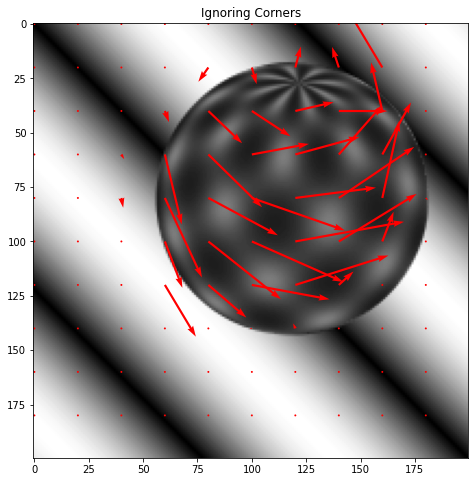

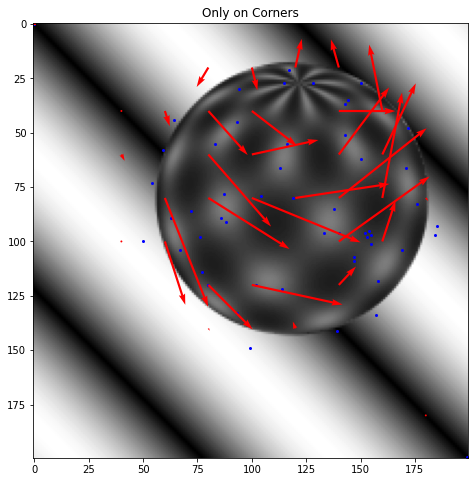

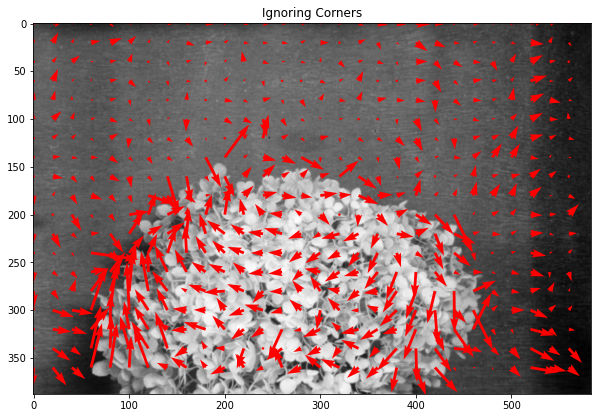

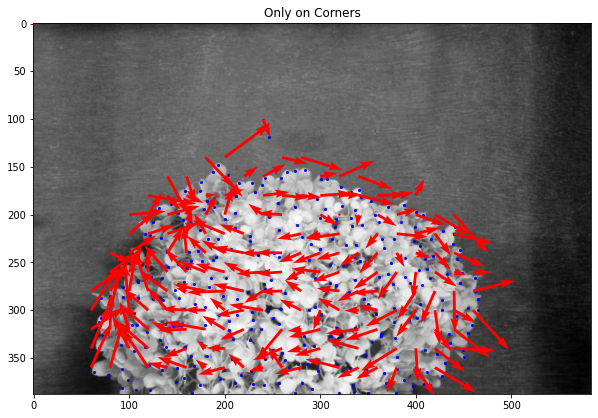

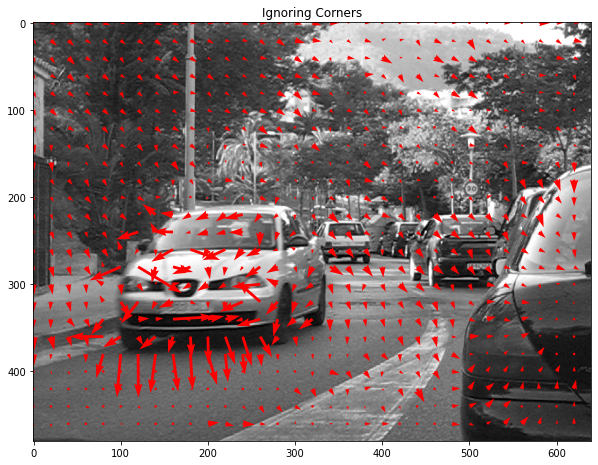

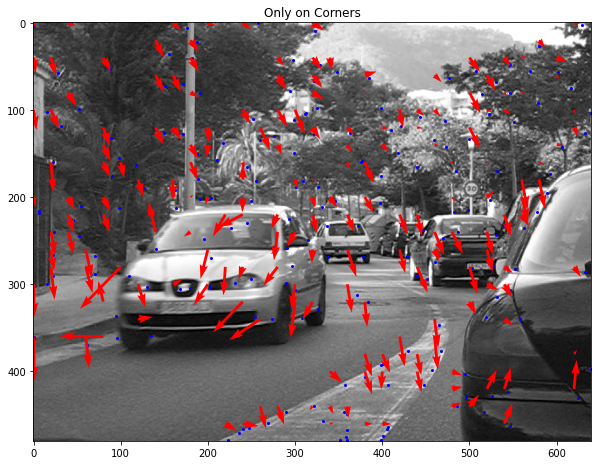

In [5]:
def load_images(name_image_t0, name_image_t1, image_dir="./data/"):
    # Load the two images
    I_t0 = cv2.imread(image_dir + name_image_t0, 0)
    I_t1 = cv2.imread(image_dir + name_image_t1, 0)

    # Convert the to np.float32
    I_t0 = I_t0.astype(np.float32)
    I_t1 = I_t1.astype(np.float32)
    
    I_t0_norm = (I_t0 - np.min(I_t0)) / (np.max(I_t0) - np.min(I_t0))
    I_t1_norm = (I_t1 - np.min(I_t1)) / (np.max(I_t1) - np.min(I_t1))

    return I_t0, I_t1

def calculate_derivatives(I_t0, I_t1):
    """
    Obtain x, y and time derivatives of an image.
    """
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    I_x = convolve2d(I_t0, sobel_x, mode='same')
    
    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])
    I_y = convolve2d(I_t0, sobel_y, mode='same')
    
    I_t = I_t1 - I_t0
    
    return I_x, I_y, I_t

# Function that separates the image into subregions
def calculate_subregions(I_t0, I_x, I_y, I_t, region_size):
    """
    input: I_t0, I_x, I_y, I_t, region_size
    I_t0: image at time t0
    I_x: image x-derivative
    I_y: image y-derivative
    I_t: image time derivative
    region_size: size of the subregions

    output: sub_I_x, sub_I_y, sub_I_t
    sub_I_x: subregions of the image x-derivative
    sub_I_y: subregions of the image y-derivative
    sub_I_t: subregions of the image time derivative
    """

    sub_I = [[], [], []]
    
    for index, image in enumerate([I_x, I_y, I_t]):
        for i in range(int(image.shape[0]/region_size)):
            for j in range(int(image.shape[1]/region_size)):
                sub_I[index].append(image[i*region_size:(i+1)*region_size, j*region_size:(j+1)*region_size])
                
    sub_I_x, sub_I_y, sub_I_t = np.array(sub_I[0]), np.array(sub_I[1]), np.array(sub_I[2])
    
    return sub_I_x, sub_I_y, sub_I_t


# Function that calulates subregions given corners
def calculate_subregions_for_corners(I_x, I_y, I_t, r, c, region_size):
    """
    Input: I_x, I_y, I_t, r, c, region_size
    I_x, I_y, I_t: image derivatives
    r, c: corners of the subregions
    region_size: size of the subregions

    Output: sub_I_x, sub_I_y, sub_I_t
    sub_I_x, sub_I_y, sub_I_t: subregions of the image derivatives
    """
    sub_I = [[], [], []]
    
    for index, image in enumerate([I_x, I_y, I_t]):
        for i in range(int(image.shape[0]/region_size)):
            for j in range(int(image.shape[1]/region_size)):
                rs = np.where((r >= i*region_size) & (r < (i+1)*region_size))[0]
                cs = np.where((c >= j*region_size) & (c < (j+1)*region_size))[0]
                corners = set(rs).intersection(set(cs))
                
                if len(corners) > 0:
                    sub_I[index].append(image[i*region_size:(i+1)*region_size, j*region_size:(j+1)*region_size])

                else:
                    sub_I[index].append(np.zeros((region_size, region_size)))
                
    sub_I_x, sub_I_y, sub_I_t = sub_I[0], sub_I[1], sub_I[2]
    
    return sub_I_x, sub_I_y, sub_I_t


# Function that computes A, A.T and b for each subregion. Then, estimate
# optical flow (Vx, Vt) as given in Equation 22.
def calculate_flow_vectors(I_x, I_y, I_t, corner=False):
    """
    Calculate the local image flow vector (Vx, Vy) for each subregion by
    solving the linear system defined above.

    Input: I_x, I_y, I_t
    I_x, I_y, I_t: image derivatives

    Output: Vx, Vy
    Vx, Vy: Two lists containing, respectively, Vx, Vy of each subregion
    """
    region_size = 20
    if corner:
        if 'sphere' in image1:
            _, r, c = haris_corner_detector("./data/" + image1, sigma=3, threshold=100, rotation=0)
        elif 'plant' in image1:
            _, r, c = haris_corner_detector("./data/" + image1, sigma=3, threshold=20000, rotation=0)
        elif 'car' in image1:
            _, r, c = haris_corner_detector("./data/" + image1, sigma=6, threshold=20000, rotation=0)
        elif 'toy' in image1:
            _, r, c = haris_corner_detector("./data/" + image1, sigma=4, threshold=750000, rotation=0)
        elif 'basketball' in image1:
            _, r, c = haris_corner_detector("./data/" + image1, sigma=4, threshold=100000, rotation=0)
        plt.scatter(c, r, color='b', s=4)
        sub_I_x, sub_I_y, sub_I_t = calculate_subregions_for_corners(I_x, I_y, I_t, r, c, region_size)
        
        subregion_indices = np.zeros((int(I_x.shape[0]/region_size), int(I_x.shape[1]/region_size), 2))
        for i in range(int(I_x.shape[0]/region_size)):
            for j in range(int(I_x.shape[1]/region_size)):
                rs = np.where((r >= i*region_size) & (r < (i+1)*region_size))[0]
                cs = np.where((c >= j*region_size) & (c < (j+1)*region_size))[0]
                corners = set(rs).intersection(set(cs))
                
                if len(corners) > 0:
                    subregion_indices[i, j, 0] = i*region_size
                    subregion_indices[i, j, 1] = j*region_size
                
    else:
        sub_I_x, sub_I_y, sub_I_t = calculate_subregions(None, I_x, I_y, I_t, region_size)
        
        subregion_indices = np.zeros((int(I_x.shape[0]/region_size), int(I_x.shape[1]/region_size), 2))
        for i in range(int(I_x.shape[0]/region_size)):
            for j in range(int(I_x.shape[1]/region_size)):
                subregion_indices[i, j, 0] = i*region_size
                subregion_indices[i, j, 1] = j*region_size
    
    Vx, Vy = [], []
    for sub_x, sub_y, sub_t in zip(sub_I_x, sub_I_y, sub_I_t):
        A = np.hstack((np.reshape(sub_x.flatten('F'), (region_size**2, 1)),
                       np.reshape(sub_y.flatten('F'), (region_size**2, 1))))
        b = - np.reshape(sub_t.flatten('F'), (region_size**2, 1))
        
        try:
            V = np.linalg.inv(A.transpose()@A)@A.transpose()@b
            #V = np.linalg.pinv(A)@b
            Vx.append(-V[0][0])
            Vy.append(V[1][0])
            
        except:
            Vx.append(0)
            Vy.append(0)
                
    plot_optical_flow(subregion_indices, Vx, Vy)
    
    return Vx, Vy

# Function that plots the optical flow vectors
def plot_optical_flow(subregion_indices, V_x, V_y):
    Vx = np.array(V_x)
    Vy = np.array(V_y)
    
    Vx = Vx/np.max(np.abs(Vx))
    Vy = Vy/np.max(np.abs(Vy))
    
    plt.quiver(subregion_indices[:, :, 1], subregion_indices[:, :, 0],
               Vx, Vy, color='r', scale_units='xy', scale=0.02, width=0.005)


#plt.figure(figsize=(16, 14))
for index, (image1, image2) in enumerate(zip(['sphere1.ppm', 'plant1.png', 'car1.jpg'],
                                             ['sphere2.ppm', 'plant2.png', 'car2.jpg'])):
    I_t0, I_t1 = load_images(image1, image2)
    I_x, I_y, I_t = calculate_derivatives(I_t0, I_t1)
    
    #plt.subplot(3, 2, index*2 + 1)
    plt.figure(figsize=(10, 8))
    plt.imshow(I_t0, cmap='gray')
    plt.title('Ignoring Corners')
    Vx, Vy = calculate_flow_vectors(I_x, I_y, I_t)
    plt.show()
    
    #plt.subplot(3, 2, index*2 + 2)
    plt.figure(figsize=(10, 8))
    plt.imshow(I_t0, cmap='gray')
    plt.title('Only on Corners')
    Vx, Vy = calculate_flow_vectors(I_x, I_y, I_t, True)
    plt.show()

#plt.show()

## Question 2.2 (5-*pts*)

Now you have seen one of the optical flow estimation methods developed by Lucas and Kanade. There are several more methods in the literature. The *[Horn-Schunck method](https://www.sciencedirect.com/science/article/abs/pii/0004370281900242)* is one of them. Check their method, compare it to Lucas-Kanade and answer the following questions:

**2.2.1** At what scale do the algorithms operate; i.e local or global? Explain your answer.


**2.2.2** How do the algorithms behave at flat regions? Explain differences/similarities.

2.2.1.
*The Lucas-Kanade algorithm work locally. This is because we are computing the flow in windows, so dividing the original image in patches and then computing the direction and magnitude of the movement for each patch. The locality of the algorithms can also be understood in terms of the optical flow assumptions. For the opitcal flow equation to be modeled, we assume that in bightness/color constancy and also that the movement is really small, both assumptions we can only work with in small windows of the image, thus indicating local scale again.*

*The Horn-Schunck algorithm, on the other hand, works globally. To do this, it introduces a global constraint of smoothness, which explains why it can still make use of the brightness/color constancy and small movement assumptions of optical flow equation.*

2.2.2.
*At flat regions it's hard to compute the optical flow because we depend on the gradient to get the x and y velocities and in flat regions the gradient of the image is basically zero. Intuitevly speaking, it's hard to tell if a patch of image is moving if it's completly flat even for humans.*

*Even though the mathematical difficulties are basically the same for both methods, they deal with it in different manners. The Lucas-Kanade method just try and compute the optical flow even in flat regions, leading to errors in the flow vector. The Horn-Schunk algorithm, on the other hand, doesn't compute the flow for flat regions, but rather fills it out with motion from the boundaries. So homogenous objects do not have weird flow behaviour, but flow movement coming from their boundary regions where it is possible to compute a proper flow vector.*

*A similar problem happens to edges, since we have strong derivatives on one direction, but very close to zero derivatives on the other dirction, leading to wrong computation of the velocity vector. Intuitevly speaking, this is a good example of the apperture problem, in which you see movement, but since you are only looking at an edge in a patch of the image, you can't be sure about the true direction of the movement.*

# 3. Feature Tracking (20-pts)

In this part of the assignment, you will implement a simple feature-tracking algorithm. The aim is to extract visual features, like corners, and track them over multiple frames.

## Question 3.1 (18-*pts*)

**3.1.1** Implement a simple feature-tracking algorithm by following below steps **[12pts]**:
    
1. Locate feature points on the first frame by using the Harris Corner Detector, that you implemented in Section 1.

2. Track these points using the Lucas-Kanade algorithm for optical flow estimation, that you implemented in the Section 2.
    
    
**3.1.2** Prepare a video for each sample image sequences. These videos should visualize the initial feature points and the optical flow. Test your implementation and prepare visualization videos for **basketball** and **toy** samples. **[6pts]**

Include a demo function to run your code.

In [ ]:
image1 = 0

for image2 in sorted(os.listdir('./data/toy')):
    if image1 != 0:
        image2 = 'toy/' + image2

        I_t0, I_t1 = load_images(image1, image2)
        I_x, I_y, I_t = calculate_derivatives(I_t0, I_t1)

        plt.figure(figsize=(10, 8))
        plt.imshow(I_t0, cmap='gray')
        plt.title('Only on Corners')
        Vx, Vy = calculate_flow_vectors(I_x, I_y, I_t, True)
        plt.show()

        image1 = image2

    else:
        image1 = 'toy/' + image2

In [ ]:
image1 = 0

for image2 in sorted(os.listdir('./data/basketball')):
    if image1 != 0:
        image2 = 'basketball/' + image2

        I_t0, I_t1 = load_images(image1, image2)
        I_x, I_y, I_t = calculate_derivatives(I_t0, I_t1)

        plt.figure(figsize=(10, 8))
        plt.imshow(I_t0, cmap='gray')
        plt.title('Only on Corners')
        Vx, Vy = calculate_flow_vectors(I_x, I_y, I_t, True)
        plt.show()

        image1 = image2

    else:
        image1 = 'basketball/' + image2

In [ ]:
image1 = 0

for image2 in sorted(os.listdir('./data/toy')):
    if image1 != 0:
        image2 = 'toy/' + image2

        I_t0, I_t1 = load_images(image1, image2)
        I_x, I_y, I_t = calculate_derivatives(I_t0, I_t1)

        plt.figure(figsize=(10, 8))
        plt.imshow(I_t0, cmap='gray')
        plt.title('Ignoring Corners')
        Vx, Vy = calculate_flow_vectors(I_x, I_y, I_t)
        plt.show()

        image1 = image2

    else:
        image1 = 'toy/' + image2

In [ ]:
image1 = 0

for image2 in sorted(os.listdir('./data/basketball')):
    if image1 != 0:
        image2 = 'basketball/' + image2

        I_t0, I_t1 = load_images(image1, image2)
        I_x, I_y, I_t = calculate_derivatives(I_t0, I_t1)

        plt.figure(figsize=(10, 8))
        plt.imshow(I_t0, cmap='gray')
        plt.title('Ignoring on Corners')
        Vx, Vy = calculate_flow_vectors(I_x, I_y, I_t, False)
        plt.show()

        image1 = image2

    else:
        image1 = 'basketball/' + image2

## Question  3.2 (2-*pts*)

Why do we need feature tracking even though we can detect features for each and every frame?

*The most important reason is that the tracking allows the continuity of object features across the frames of the video. If you are interested in the motion of an object, like in our assignment, feature tracking makes it possible to follow this motion across multiple frames.*

*Aside from the continuity, feature tracking can also be more efficient while it is not necessary to re-detect an object every frame once it is correctly identified in the beginning of the video.*

# X Individual Contribution Report *(Mandatory)*

Because we want each student to contribute fairly to the submitted work, we ask you to fill out the textcells below. Write down your contribution to each of the assignment components in percentages. Naturally, percentages for one particular component should add up to 100% (e.g. 30% - 30% - 40%). No further explanation has to be given.


Name: Luis Zerkowski

Contribution on research: 33.33\
Contribution on programming: 33.33\
Contribution on writing: 33.33

Name: Tanya Kaintura

Contribution on research: 33.33\
Contribution on programming: 33.33\
Contribution on writing: 33.33

Name: Jelle van der Lee

Contribution on research: 33.33\
Contribution on programming: 33.33\
Contribution on writing: 33.33

# - End of notebook -